In [1]:
from yahoo_fin import options as op
import yfinance as yf
import pandas as pd
import re
import ta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import optuna

C:\ProgramData\anaconda3\envs\StockEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ticker = 'SPY'

In [3]:
symbol = "SPY"
start_date = "1999-01-01"  
end_date = "2024-04-12"  

In [4]:
option_hist_data = yf.download(symbol, start=start_date, end=end_date, actions=False)
print(option_hist_data)

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1999-01-04  123.375000  125.218750  121.718750  123.031250   78.329697   
1999-01-05  122.937500  124.875000  122.937500  124.437500   79.225029   
1999-01-06  125.812500  127.750000  125.750000  127.437500   81.134972   
1999-01-07  126.375000  127.218750  125.781250  126.812500   80.737083   
1999-01-08  128.187500  128.500000  125.968750  127.750000   81.333969   
...                ...         ...         ...         ...         ...   
2024-04-05  514.460022  520.440002  514.010010  518.429993  518.429993   
2024-04-08  519.150024  520.179993  517.890015  518.719971  518.719971   
2024-04-09  520.500000  520.750000  514.349976  519.320007  519.320007   
2024-04-10  513.479980  516.159973  512.090027  514.119995  514.119995   
2024-04-11  515.679993  519.479980  512.080017  518.000000  518.000000   

              Volume  
Date          

In [5]:
# Calculate SMA and RSI
data = option_hist_data.copy()
data['SMA'] = data['Close'].rolling(window=20).mean()
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Calculate EMA
short_window = 12
long_window = 26
signal_window = 9
data['EMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()

# Calculate MACD Histogram
def calculate_macd_histogram(data, short_window=12, long_window=26, signal_window=9):
    ema_short = data['Close'].ewm(span=short_window, adjust=False).mean()
    ema_long = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_histogram
data['MACD Histogram'] = calculate_macd_histogram(data)

# Calculate VWAP
data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

# Calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (2 * rolling_std)
    lower_band = rolling_mean - (2 * rolling_std)
    return upper_band, lower_band

data['Upper BB'], data['Lower BB'] = calculate_bollinger_bands(data)

# Calculate Stochastic Oscillator
def calculate_stochastic_oscillator(data, window=14):
    low_min = data['Low'].rolling(window=window).min()
    high_max = data['High'].rolling(window=window).max()
    k_percent = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    return k_percent

data['Stochastic Oscillator'] = calculate_stochastic_oscillator(data)

# Calculate Average True Range (ATR)
def calculate_atr(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

data['ATR'] = calculate_atr(data)

# Calculate On-Balance Volume (OBV)
def calculate_obv(data):
    obv = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()
    return obv

data['OBV'] = calculate_obv(data)

def calculate_mfi(data, window=14):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    money_flow = typical_price * data['Volume']
    money_flow_positive = np.where(typical_price.diff() > 0, money_flow, 0)
    money_flow_negative = np.where(typical_price.diff() < 0, money_flow, 0)
    positive_flow_sum = pd.Series(money_flow_positive).rolling(window=window).sum()
    negative_flow_sum = pd.Series(money_flow_negative).rolling(window=window).sum()
    
    # Avoid division by zero error
    with np.errstate(divide='ignore', invalid='ignore'):
        money_ratio = np.where(negative_flow_sum != 0, positive_flow_sum / negative_flow_sum, 0)
    
    mfi = 100 - (100 / (1 + money_ratio))
    return mfi

data['MFI'] = calculate_mfi(data)

# Calculate Chaikin Money Flow (CMF)
def calculate_cmf(data, window=20):
    money_flow_multiplier = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
    money_flow_volume = money_flow_multiplier * data['Volume']
    cmf = money_flow_volume.rolling(window=window).sum() / data['Volume'].rolling(window=window).sum()
    return cmf

data['CMF'] = calculate_cmf(data)

In [6]:
# Reset the index to default integer index before saving to CSV
data.reset_index(inplace=True)

# Drop rows with missing data
data.dropna(inplace=True)

# Save the modified DataFrame to CSV with the 'Date' column included
data.to_csv('OptionHistData.csv', columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA', 'RSI', 'EMA', 'MACD Histogram', 'VWAP', 'Upper BB', 'Lower BB', 'Stochastic Oscillator', 'ATR', 'OBV', 'MFI', 'CMF'], index=False)

In [7]:
print(data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA', 'RSI', 'EMA', 'MACD Histogram', 'VWAP', 'Upper BB', 'Lower BB', 'Stochastic Oscillator', 'ATR', 'OBV', 'MFI', 'CMF']])

           Date        Open        High         Low       Close   Adj Close  \
19   1999-02-01  128.687500  128.687500  126.906250  126.906250   80.796783   
20   1999-02-02  127.078125  127.218750  124.765625  126.125000   80.299347   
21   1999-02-03  125.687500  127.937500  125.656250  127.406250   81.115112   
22   1999-02-04  127.375000  127.500000  124.781250  125.500000   79.901474   
23   1999-02-05  125.656250  125.656250  123.218750  124.062500   78.986275   
...         ...         ...         ...         ...         ...         ...   
6354 2024-04-05  514.460022  520.440002  514.010010  518.429993  518.429993   
6355 2024-04-08  519.150024  520.179993  517.890015  518.719971  518.719971   
6356 2024-04-09  520.500000  520.750000  514.349976  519.320007  519.320007   
6357 2024-04-10  513.479980  516.159973  512.090027  514.119995  514.119995   
6358 2024-04-11  515.679993  519.479980  512.080017  518.000000  518.000000   

        Volume         SMA        RSI         EMA  

<Axes: >

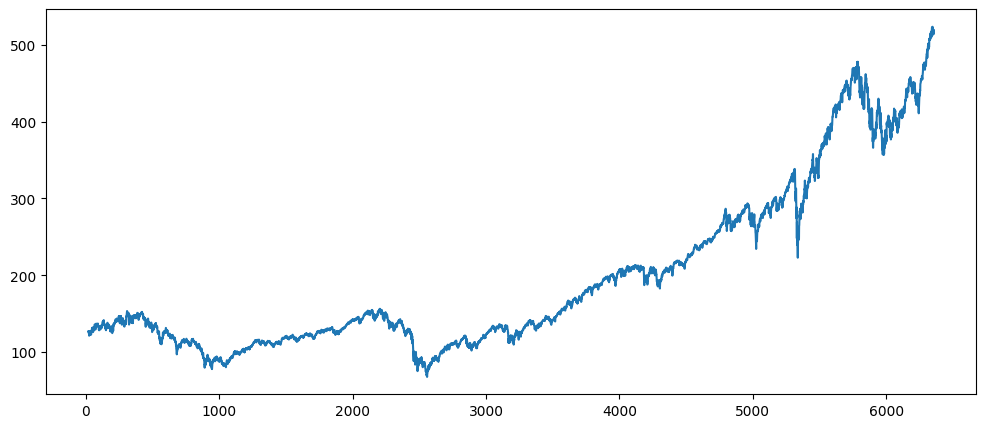

In [8]:
data['Close'].plot(figsize=(12,5))

In [9]:
from statsmodels.tsa.stattools import adfuller
def ad_test(data): 
    dftest = adfuller(data, autolag = 'AIC')
    print("ADF:", dftest[0])
    print("P-Value", dftest[1])
    print("Num of Lags", dftest[2])
    print("Num of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("Critical Values :")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [10]:
ad_test(data['Close'])

ADF: 2.13152559630096
P-Value 0.9988212672045651
Num of Lags 32
Num of Observations Used For ADF Regression and Critical Values Calculation : 6307
Critical Values :
	 1% :  -3.431387254397357
	 5% :  -2.8619983751901326
	 10% :  -2.567013990071056


Epoch 1/50
157/157 [==============================] - 4s 18ms/step - loss: 0.0182 - val_loss: 1.5388e-04
Epoch 2/50
157/157 [==============================] - 3s 16ms/step - loss: 1.4678e-04 - val_loss: 1.1864e-04
Epoch 3/50
157/157 [==============================] - 3s 18ms/step - loss: 1.1984e-04 - val_loss: 1.0404e-04
Epoch 4/50
157/157 [==============================] - 3s 18ms/step - loss: 1.0539e-04 - val_loss: 1.0031e-04
Epoch 5/50
157/157 [==============================] - 3s 18ms/step - loss: 9.8817e-05 - val_loss: 9.5480e-05
Epoch 6/50
157/157 [==============================] - 3s 18ms/step - loss: 1.0006e-04 - val_loss: 9.2219e-05
Epoch 7/50
157/157 [==============================] - 3s 17ms/step - loss: 9.2531e-05 - val_loss: 9.7156e-05
Epoch 8/50
157/157 [==============================] - 3s 18ms/step - loss: 9.2494e-05 - val_loss: 9.6124e-05
Epoch 9/50
157/157 [==============================] - 3s 19ms/step - loss: 8.6106e-05 - val_loss: 1.1230e-04
Epoch 10/50
157/157 [==

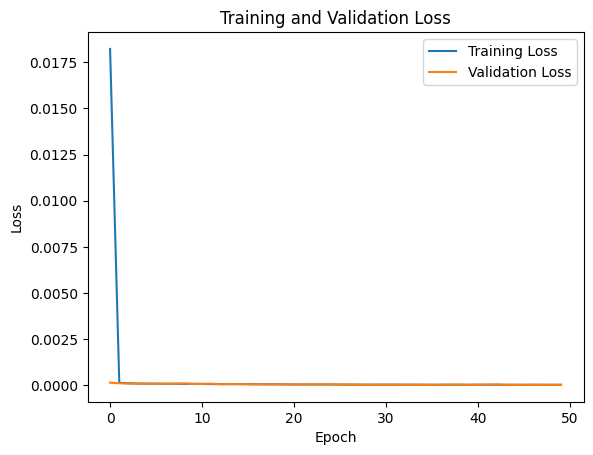

20/20 [==============================] - 0s 7ms/step
Test Set Performance Metrics:
Mean Squared Error: 8.799903883291858
Mean Absolute Error: 1.7783708633131285
R-squared: 0.9992091818149356

Actual vs Predicted Values on Test Set:
         Actual   Predicted
0    383.790009  383.283600
1     75.620003   76.716263
2    115.720001  116.266556
3    129.710007  131.825836
4     89.650002   91.689049
..          ...         ...
623  437.250000  435.498688
624  110.410004  109.978256
625  163.559998  164.014084
626  135.110001  135.077881
627  109.989998  109.744614

[628 rows x 2 columns]
1/1 [==============================] - 0s 23ms/step
Predictions for the Next 6 Days:
[[515.1653 ]
 [514.80597]
 [513.6776 ]
 [512.6597 ]
 [511.69144]
 [510.7389 ]]


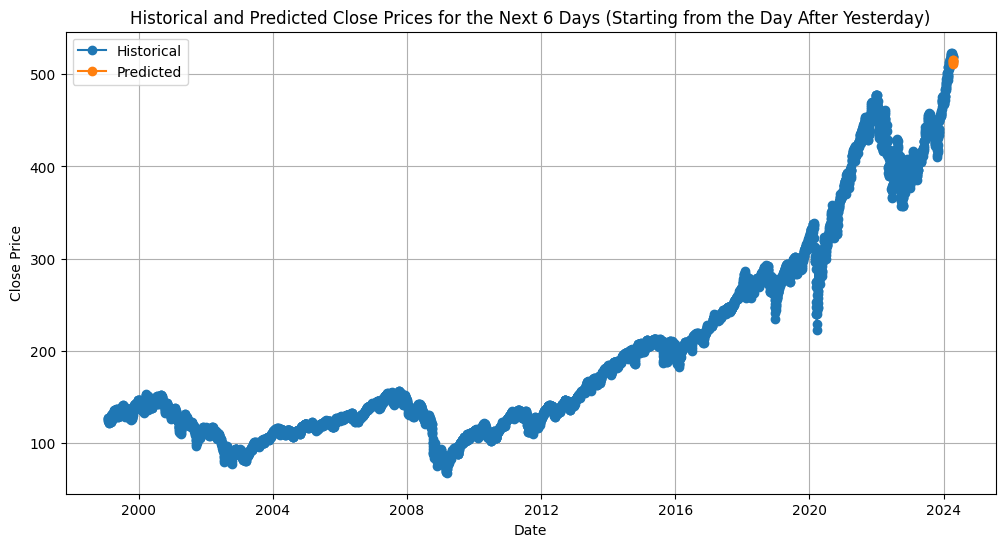

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load historical data
data = pd.read_csv('OptionHistData.csv', parse_dates=['Date'])

# Assuming 'features' and 'target' are defined as before
features = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA', 'RSI', 'EMA', 'MACD Histogram', 'VWAP', 'Upper BB', 'Lower BB', 'Stochastic Oscillator', 'ATR', 'OBV', 'MFI', 'CMF']
target = 'Close'

# Filter data for the data up to yesterday
data_up_to_yesterday = data[data['Date'] < '2024-04-12']

# Extract the target variable
y = data_up_to_yesterday[target].values.reshape(-1, 1)

# Feature scaling
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

# Function to prepare the data for LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

# Choose the number of time steps (lookback) for the LSTM model
n_steps = 60

# Prepare the data
X, y = prepare_data(y_scaled, n_steps)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape input data to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Set random seed for reproducibility
np.random.seed(42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Train the model with a validation set
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=(X_val, y_val)  # Add validation data
)

# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predict on the test set
y_pred_test = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred_test = scaler.inverse_transform(y_pred_test)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate performance on the test set
mse_test = mean_squared_error(y_test_actual, y_pred_test)
mae_test = mean_absolute_error(y_test_actual, y_pred_test)
r2_test = r2_score(y_test_actual, y_pred_test)

print("Test Set Performance Metrics:")
print("Mean Squared Error:", mse_test)
print("Mean Absolute Error:", mae_test)
print("R-squared:", r2_test)

# Print actual and predicted values on the test set
test_results = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': y_pred_test.flatten()})
print("\nActual vs Predicted Values on Test Set:")
print(test_results)

# Prepare data for predicting the next 6 days
X_predict = y[-n_steps:].reshape((1, n_steps, 1))
predictions_6_days_scaled = []

# Make predictions for the next 6 days
for day in range(6):
    prediction_scaled = model.predict(X_predict)
    predictions_6_days_scaled.append(prediction_scaled[0, 0])

    # Update X_predict for the next day's prediction
    X_predict = np.roll(X_predict, shift=-1)
    X_predict[0, -1, 0] = prediction_scaled[0, 0]

# Inverse transform the scaled predictions
predictions_6_days = scaler.inverse_transform(np.array(predictions_6_days_scaled).reshape(-1, 1))

# Print the predictions for the next 6 days
print("Predictions for the Next 6 Days:")
print(predictions_6_days)

# Visualize the predictions for the next 6 days
plt.figure(figsize=(12, 6))
plt.plot(data_up_to_yesterday['Date'], data_up_to_yesterday['Close'], label='Historical Close Prices', marker='o')
plt.plot(pd.date_range(start=data_up_to_yesterday['Date'].max() + pd.Timedelta(days=1), periods=6, freq='D'), predictions_6_days, label='Predicted Close Prices for Next 6 Days', marker='o')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical and Predicted Close Prices for the Next 6 Days (Starting from the Day After Yesterday)')
plt.legend(['Historical', 'Predicted'])
plt.grid(True)
plt.show()

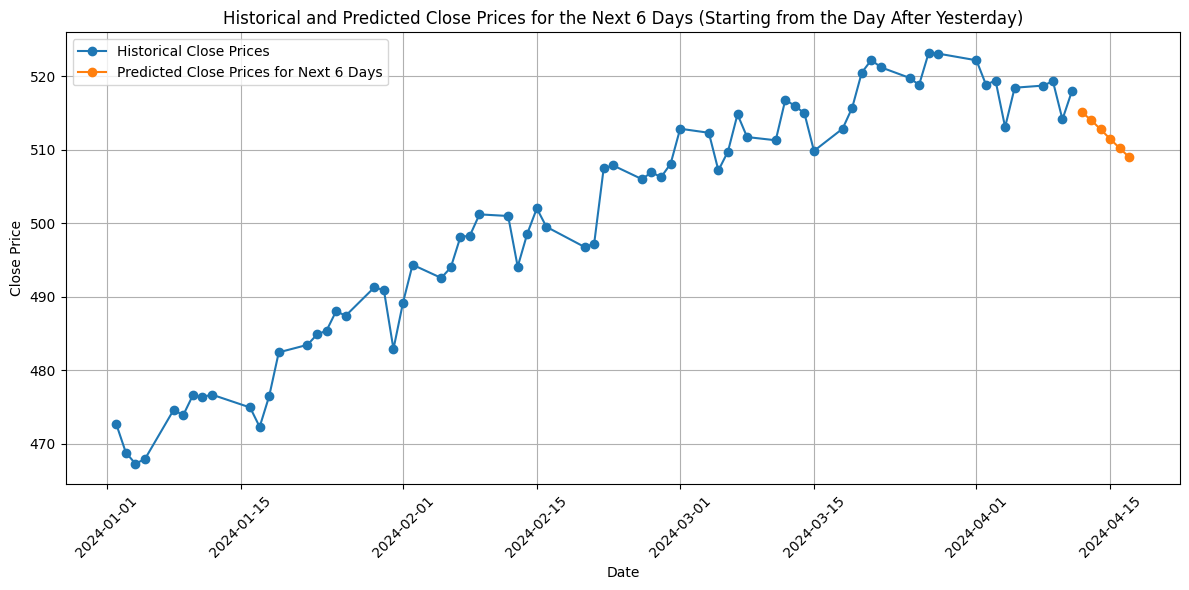

In [12]:
plt.figure(figsize=(12, 6))

# Plotting historical data
plt.plot(data_up_to_yesterday[data_up_to_yesterday['Date'] >= '2024-01-01']['Date'],
         data_up_to_yesterday[data_up_to_yesterday['Date'] >= '2024-01-01']['Close'],
         label='Historical Close Prices',
         marker='o')

# Generating dates for the next 6 days
next_6_days_dates = pd.date_range(start=data_up_to_yesterday['Date'].max() + pd.Timedelta(days=1), periods=6, freq='D')

# Plotting predicted data for the next 6 days
plt.plot(next_6_days_dates,
         predictions_6_days,
         label='Predicted Close Prices for Next 6 Days',
         marker='o')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical and Predicted Close Prices for the Next 6 Days (Starting from the Day After Yesterday)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [13]:
from yahoo_fin import options as op

# Specify the ticker symbol for options
ticker = "QQQ"

# Get all the option data for the specified ticker
all_option_data = op.get_options_chain(ticker)

# Access the call and put option data
call_options = all_option_data["calls"]
put_options = all_option_data["puts"]

# Print the call and put option data
print("Call Options:")
print(call_options)
print("\nPut Options:")
print(put_options)

C:\ProgramData\anaconda3\envs\StockEnv\Lib\site-packages\yahoo_fin\options.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(requests.get(site, headers=headers).text)


Call Options:
         Contract Name         Last Trade Date  Strike  Last Price    Bid  \
0   QQQ240415C00372000   2024-04-12 9:32AM EDT   372.0       69.51  66.28   
1   QQQ240415C00380000   2024-04-12 3:38PM EDT   380.0       57.49  58.19   
2   QQQ240415C00381000   2024-04-12 3:39PM EDT   381.0       56.35  57.20   
3   QQQ240415C00382000   2024-04-10 2:52PM EDT   382.0       56.32  56.20   
4   QQQ240415C00383000   2024-04-11 2:45PM EDT   383.0       63.00  55.20   
..                 ...                     ...     ...         ...    ...   
78  QQQ240415C00480000  2024-04-08 12:10PM EDT   480.0        0.01   0.00   
79  QQQ240415C00481000  2024-04-08 12:13PM EDT   481.0        0.01   0.00   
80  QQQ240415C00486000   2024-04-05 2:21PM EDT   486.0        0.01   0.00   
81  QQQ240415C00489000  2024-04-03 11:58AM EDT   489.0        0.01   0.00   
82  QQQ240415C00490000   2024-04-04 2:57PM EDT   490.0        0.01   0.00   

      Ask  Change % Change Volume  Open Interest Implied Vola